# Psl intensity analysis — site & group comparisons
**Author:** Terence Makuvise  
**Data file:** `psl_data.csv` (columns: `subject_id`, `genotype`, `site`, `psl_intensity`)  
**Goal:** 1) One-way ANOVA per site (infection vs distant) + Tukey post-hoc.  
2) Mixed ANOVA (between = genotype, within = site) to test genotype × site interactions.  
3) Publication-style plots with significance annotations and paired-subject lines.


In [2]:
# Cell 1 — (Optional) Install packages if not present
# Run this cell only if you get import errors later. Uncomment to install.
# !pip install pandas numpy matplotlib seaborn statsmodels scipy pingouin


In [3]:
# Cell 2 — Imports & plotting settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# statsmodels imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# pingouin for mixed ANOVA
import pingouin as pg

# Set publication-quality plotting parameters
def set_publication_style():
    """Set publication-quality plotting parameters"""
    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 14,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'axes.titleweight': 'bold',
        'axes.labelweight': 'semibold',
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'grid.linewidth': 0.5
    })
    sns.set_style("whitegrid")

set_publication_style()

# Define professional color palettes
palette = {
    'A': '#2E86AB',  # Blue
    'B': '#A23B72',  # Purple
    'C': '#F18F01',  # Orange
}

site_palette = {
    'infection': '#C73E1D',  # Red
    'distant': '#2E86AB'    # Blue
}

# Create figures directory
if not os.path.exists('figures'):
    os.makedirs('figures')



In [4]:
# Cell 3 — Load data (adjust path if necessary)
data_path = 'psl_data.csv'   # change to 'data/psl_data.csv' if needed
df = pd.read_csv(data_path)
print("Data loaded from:", data_path)
print("Rows, cols:", df.shape)
df.head(10)


Data loaded from: psl_data.csv
Rows, cols: (24, 4)


,subject_id,genotype,site,psl_intensity
0,B0200,A,Infection,2510.262
1,B0200,A,Distant,3127.989
2,B0201,A,Infection,3251.497
3,B0201,A,Distant,2387.711
4,B0202,A,Infection,3581.017
5,B0202,A,Distant,2058.310
6,B0203,A,Infection,4559.828
7,B0203,A,Distant,3126.701
8,B0204,B,Infection,903.737
9,B0204,B,Distant,740.962


In [5]:
# Cell 4 — Basic validation & tidy-up/ preprocessing
# Expected columns: subject_id, genotype, site, psl_intensity

print("Columns in file:", df.columns.tolist())

# Standardize column names
df.columns = [c.strip().lower() for c in df.columns]

# Verify required columns
required = ['genotype', 'site', 'psl_intensity']
if not set(required).issubset(df.columns):
    raise ValueError(f"CSV missing required columns. Must include at least {required}")

# Create subject_id if missing
if 'subject_id' not in df.columns:
    df['subject_id'] = np.arange(len(df)).astype(str)
    print("Warning: 'subject_id' column not provided — synthetic id column created")

# Clean text columns
df['genotype'] = df['genotype'].astype(str).str.strip().str.upper()
df['site'] = df['site'].astype(str).str.strip().str.lower()

# Quick summary
print("\nSummary counts by genotype and site:")
print(pd.crosstab(df['genotype'], df['site']))
print("\nAny missing psl_intensity values? ", df['psl_intensity'].isnull().sum())

Columns in file: ['subject_id', 'genotype', 'site', 'psl_intensity']

Summary counts by genotype and site:
site      distant  infection
genotype                    
A               4          4
B               4          4
C               4          4

Any missing psl_intensity values?  0


In [6]:
# Cell 5 — Descriptive statistics
print("Descriptive statistics by genotype & site:")
summary_stats = df.groupby(['site', 'genotype'])['psl_intensity'].agg([
    'mean', 'std', 'sem', 'count', 'min', 'max', 
    lambda x: x.quantile(0.25), 
    lambda x: x.quantile(0.75)
]).round(2)

summary_stats.columns = ['Mean', 'SD', 'SEM', 'N', 'Min', 'Max', 'Q1', 'Q3']
display(summary_stats)

# Save summary statistics
summary_stats.to_csv('figures/descriptive_statistics.csv')
print("Saved descriptive statistics to figures/descriptive_statistics.csv")


Descriptive statistics by genotype & site:


Mean      SD     SEM  N      Min      Max       Q1  \
site      genotype                                                          
distant   A         2675.18  539.16  269.58  4  2058.31  3127.99  2305.36   
          B          915.66  427.50  213.75  4   412.79  1387.33   658.92   
          C         2127.24  407.49  203.75  4  1597.24  2585.87  1986.47   
infection A         3475.65  850.25  425.12  4  2510.26  4559.83  3066.19   
          B          795.78   87.28   43.64  4   691.40   903.74   759.20   
          C         2586.17  907.38  453.69  4  1992.33  3927.38  2052.42   

                         Q3  
site      genotype           
distant   A         3127.02  
          B         1188.00  
          C         2303.68  
infection A         3825.72  
          B          830.59  
          C         2746.25

Saved descriptive statistics to figures/descriptive_statistics.csv


In [7]:
# Cell 6 — One-way ANOVAs per site + Tukey HSD
print("=" * 60)
print("ONE-WAY ANOVA ANALYSIS PER SITE")
print("=" * 60)

anova_results = {}
tukey_results = {}

for site in sorted(df['site'].unique()):
    print(f"\n{site.upper()} SITE:")
    print("-" * 40)
    
    sub = df[df['site'] == site].copy()
    
    # One-way ANOVA
    model = ols('psl_intensity ~ C(genotype)', data=sub).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[site] = anova_table
    
    print("ANOVA Results:")
    print(f"F({int(anova_table.loc['C(genotype)', 'df'])}, "
          f"{int(anova_table.loc['Residual', 'df'])}) = "
          f"{anova_table.loc['C(genotype)', 'F']:.3f}, "
          f"p = {anova_table.loc['C(genotype)', 'PR(>F)']:.4f}")
    
    # Effect size (eta squared)
    ss_effect = anova_table.loc['C(genotype)', 'sum_sq']
    ss_total = ss_effect + anova_table.loc['Residual', 'sum_sq']
    eta_squared = ss_effect / ss_total
    print(f"η² = {eta_squared:.3f}")
    
    # Tukey HSD post-hoc test
    try:
        tuk = pairwise_tukeyhsd(
            endog=sub['psl_intensity'], 
            groups=sub['genotype'], 
            alpha=0.05
        )
        tuk_df = pd.DataFrame(data=tuk.summary().data[1:], 
                             columns=tuk.summary().data[0])
        tukey_results[site] = tuk_df
        
        print("\nTukey HSD Results (α = 0.05):")
        print("-" * 60)
        for _, row in tuk_df.iterrows():
            sig = "*" if row['reject'] else "ns"
            print(f"{row['group1']} vs {row['group2']}: "
                  f"Δ = {float(row['meandiff']):.1f}, "
                  f"p = {float(row['p-adj']):.4f} [{sig}]")
        
    except Exception as e:
        print(f"Tukey test failed: {e}")

# Save ANOVA results
for site, table in anova_results.items():
    table.to_csv(f'figures/anova_{site}.csv')
    print(f"\nSaved {site} ANOVA results to figures/anova_{site}.csv")

ONE-WAY ANOVA ANALYSIS PER SITE

DISTANT SITE:
----------------------------------------
ANOVA Results:
F(2, 9) = 15.212, p = 0.0013
η² = 0.772

Tukey HSD Results (α = 0.05):
------------------------------------------------------------
A vs B: Δ = -1759.5, p = 0.0011 [*]
A vs C: Δ = -547.9, p = 0.2650 [ns]
B vs C: Δ = 1211.6, p = 0.0121 [*]

INFECTION SITE:
----------------------------------------
ANOVA Results:
F(2, 9) = 14.388, p = 0.0016
η² = 0.762

Tukey HSD Results (α = 0.05):
------------------------------------------------------------
A vs B: Δ = -2679.9, p = 0.0013 [*]
A vs C: Δ = -889.5, p = 0.2408 [ns]
B vs C: Δ = 1790.4, p = 0.0162 [*]

Saved distant ANOVA results to figures/anova_distant.csv

Saved infection ANOVA results to figures/anova_infection.csv


In [8]:
# Cell 7 — Mixed ANOVA: genotype (between) × site (within)
print("\n" + "=" * 60)
print("MIXED ANOVA: GENOTYPE × SITE INTERACTION")
print("=" * 60)

try:
    # Prepare data for mixed ANOVA
    df_mixed = df.copy()
    df_mixed['site'] = df_mixed['site'].astype('category')
    
    # Run mixed ANOVA using pingouin
    mixed = pg.mixed_anova(
        dv='psl_intensity',
        between='genotype',
        within='site',
        subject='subject_id',
        data=df_mixed
    )
    
    print("Mixed ANOVA Results:")
    print("-" * 60)
    for _, row in mixed.iterrows():
        if row['Source'] != 'Residual':
            sig = "*" if row['p-unc'] < 0.05 else "ns"
            print(f"{row['Source']}: F({int(row['DF1'])}, {int(row['DF2'])}) = "
                  f"{row['F']:.3f}, p = {row['p-unc']:.4f} [{sig}], "
                  f"η² = {row['np2']:.3f}")
    
    # Save mixed ANOVA results
    mixed.to_csv('figures/mixed_anova_results.csv', index=False)
    print("\nSaved mixed ANOVA results to figures/mixed_anova_results.csv")
    
    mixed_anova = mixed
    
except Exception as e:
    print(f"Mixed ANOVA failed: {e}")
    print("\nAttempting Linear Mixed Model as alternative...")
    
    import statsmodels.formula.api as smf
    df_mixed['genotype'] = df_mixed['genotype'].astype('category')
    formula = 'psl_intensity ~ C(genotype) * C(site)'
    md = smf.mixedlm(formula, df_mixed, groups=df_mixed['subject_id'])
    mdf = md.fit(reml=False)
    print(mdf.summary())
    mixed_anova = None



MIXED ANOVA: GENOTYPE × SITE INTERACTION
Mixed ANOVA Results:
------------------------------------------------------------
genotype: F(2, 9) = 27.663, p = 0.0001 [*], η² = 0.860
site: F(1, 9) = 2.404, p = 0.1555 [ns], η² = 0.211
Interaction: F(2, 9) = 1.202, p = 0.3446 [ns], η² = 0.211

Saved mixed ANOVA results to figures/mixed_anova_results.csv


In [9]:
# Cell 8 — Pairwise comparisons with multiple testing correction
print("\n" + "=" * 60)
print("PAIRWISE COMPARISONS WITH BONFERRONI CORRECTION")
print("=" * 60)

pairwise_list = []
for site in sorted(df['site'].unique()):
    sub = df[df['site'] == site]
    genotypes = sub['genotype'].unique()
    
    for i in range(len(genotypes)):
        for j in range(i + 1, len(genotypes)):
            g1, g2 = genotypes[i], genotypes[j]
            x = sub[sub['genotype'] == g1]['psl_intensity']
            y = sub[sub['genotype'] == g2]['psl_intensity']
            
            # Independent t-test
            t_stat, p_val = stats.ttest_ind(x, y, equal_var=False)
            cohen_d = (x.mean() - y.mean()) / np.sqrt((x.std()**2 + y.std()**2) / 2)
            
            pairwise_list.append({
                'site': site,
                'g1': g1,
                'g2': g2,
                't_stat': t_stat,
                'p_uncorrected': p_val,
                'cohen_d': cohen_d,
                'mean_diff': x.mean() - y.mean()
            })

pairwise_df = pd.DataFrame(pairwise_list)

# Apply Bonferroni correction
pairwise_df['p_adj'] = multipletests(
    pairwise_df['p_uncorrected'], 
    method='bonferroni'
)[1]

print("Pairwise comparisons (Bonferroni-corrected):")
print("-" * 60)
for _, row in pairwise_df.iterrows():
    sig = "*" if row['p_adj'] < 0.05 else "ns"
    print(f"{row['site'].capitalize()}: {row['g1']} vs {row['g2']}: "
          f"t = {row['t_stat']:.3f}, p = {row['p_adj']:.4f} [{sig}], "
          f"d = {row['cohen_d']:.3f}")

# Save pairwise results
pairwise_df.to_csv('figures/pairwise_genotype_site_results.csv', index=False)
print("\nSaved pairwise results to figures/pairwise_genotype_site_results.csv")



PAIRWISE COMPARISONS WITH BONFERRONI CORRECTION
Pairwise comparisons (Bonferroni-corrected):
------------------------------------------------------------
Distant: A vs B: t = 5.114, p = 0.0153 [*], d = 3.616
Distant: A vs C: t = 1.622, p = 0.9582 [ns], d = 1.147
Distant: B vs C: t = -4.103, p = 0.0382 [*], d = -2.901
Infection: A vs B: t = 6.271, p = 0.0462 [*], d = 4.434
Infection: A vs C: t = 1.431, p = 1.0000 [ns], d = 1.012
Infection: B vs C: t = -3.928, p = 0.1704 [ns], d = -2.778

Saved pairwise results to figures/pairwise_genotype_site_results.csv


In [10]:
# Cell 9 — Helper function for significance annotations
def add_sig_bar(ax, x1, x2, y, pval, lineheight=0.04, linewidth=1.5, fontsize=11):
    """
    Add significance annotation bar between two points
    
    Parameters:
    -----------
    ax : matplotlib axis
    x1, x2 : x positions
    y : y position for bar
    pval : p-value for determining significance level
    lineheight : height of bracket
    linewidth : line width
    fontsize : font size for annotation
    """
    # Determine significance level
    if pval < 0.001:
        text = '***'
        color = '#2E7D32'  # Dark green for high significance
    elif pval < 0.01:
        text = '**'
        color = '#689F38'  # Medium green
    elif pval < 0.05:
        text = '*'
        color = '#9CCC65'  # Light green
    else:
        text = 'ns'
        color = '#757575'  # Gray for non-significant
    
    # Draw bracket
    ax.plot([x1, x1, x2, x2], 
           [y, y + lineheight, y + lineheight, y], 
           lw=linewidth, c=color, solid_capstyle='butt')
    
    # Add text
    ax.text((x1 + x2) / 2, y + lineheight * 1.3, text, 
           ha='center', va='bottom', fontsize=fontsize, 
           fontweight='bold', color=color)

def plot_confidence_interval(ax, x, mean, ci, color='black', 
                           capsize=5, linewidth=1.5):
    """
    Plot confidence interval as error bar
    
    Parameters:
    -----------
    ax : matplotlib axis
    x : x position
    mean : mean value
    ci : confidence interval (half-width)
    color : error bar color
    capsize : cap size
    linewidth : line width
    """
    ax.errorbar(x, mean, yerr=ci, fmt='none',
               color=color, capsize=capsize, 
               capthick=linewidth, linewidth=linewidth)


Creating enhanced visualization: Main Effects Plot
Saved main effects figure to figures/psl_main_effects.png


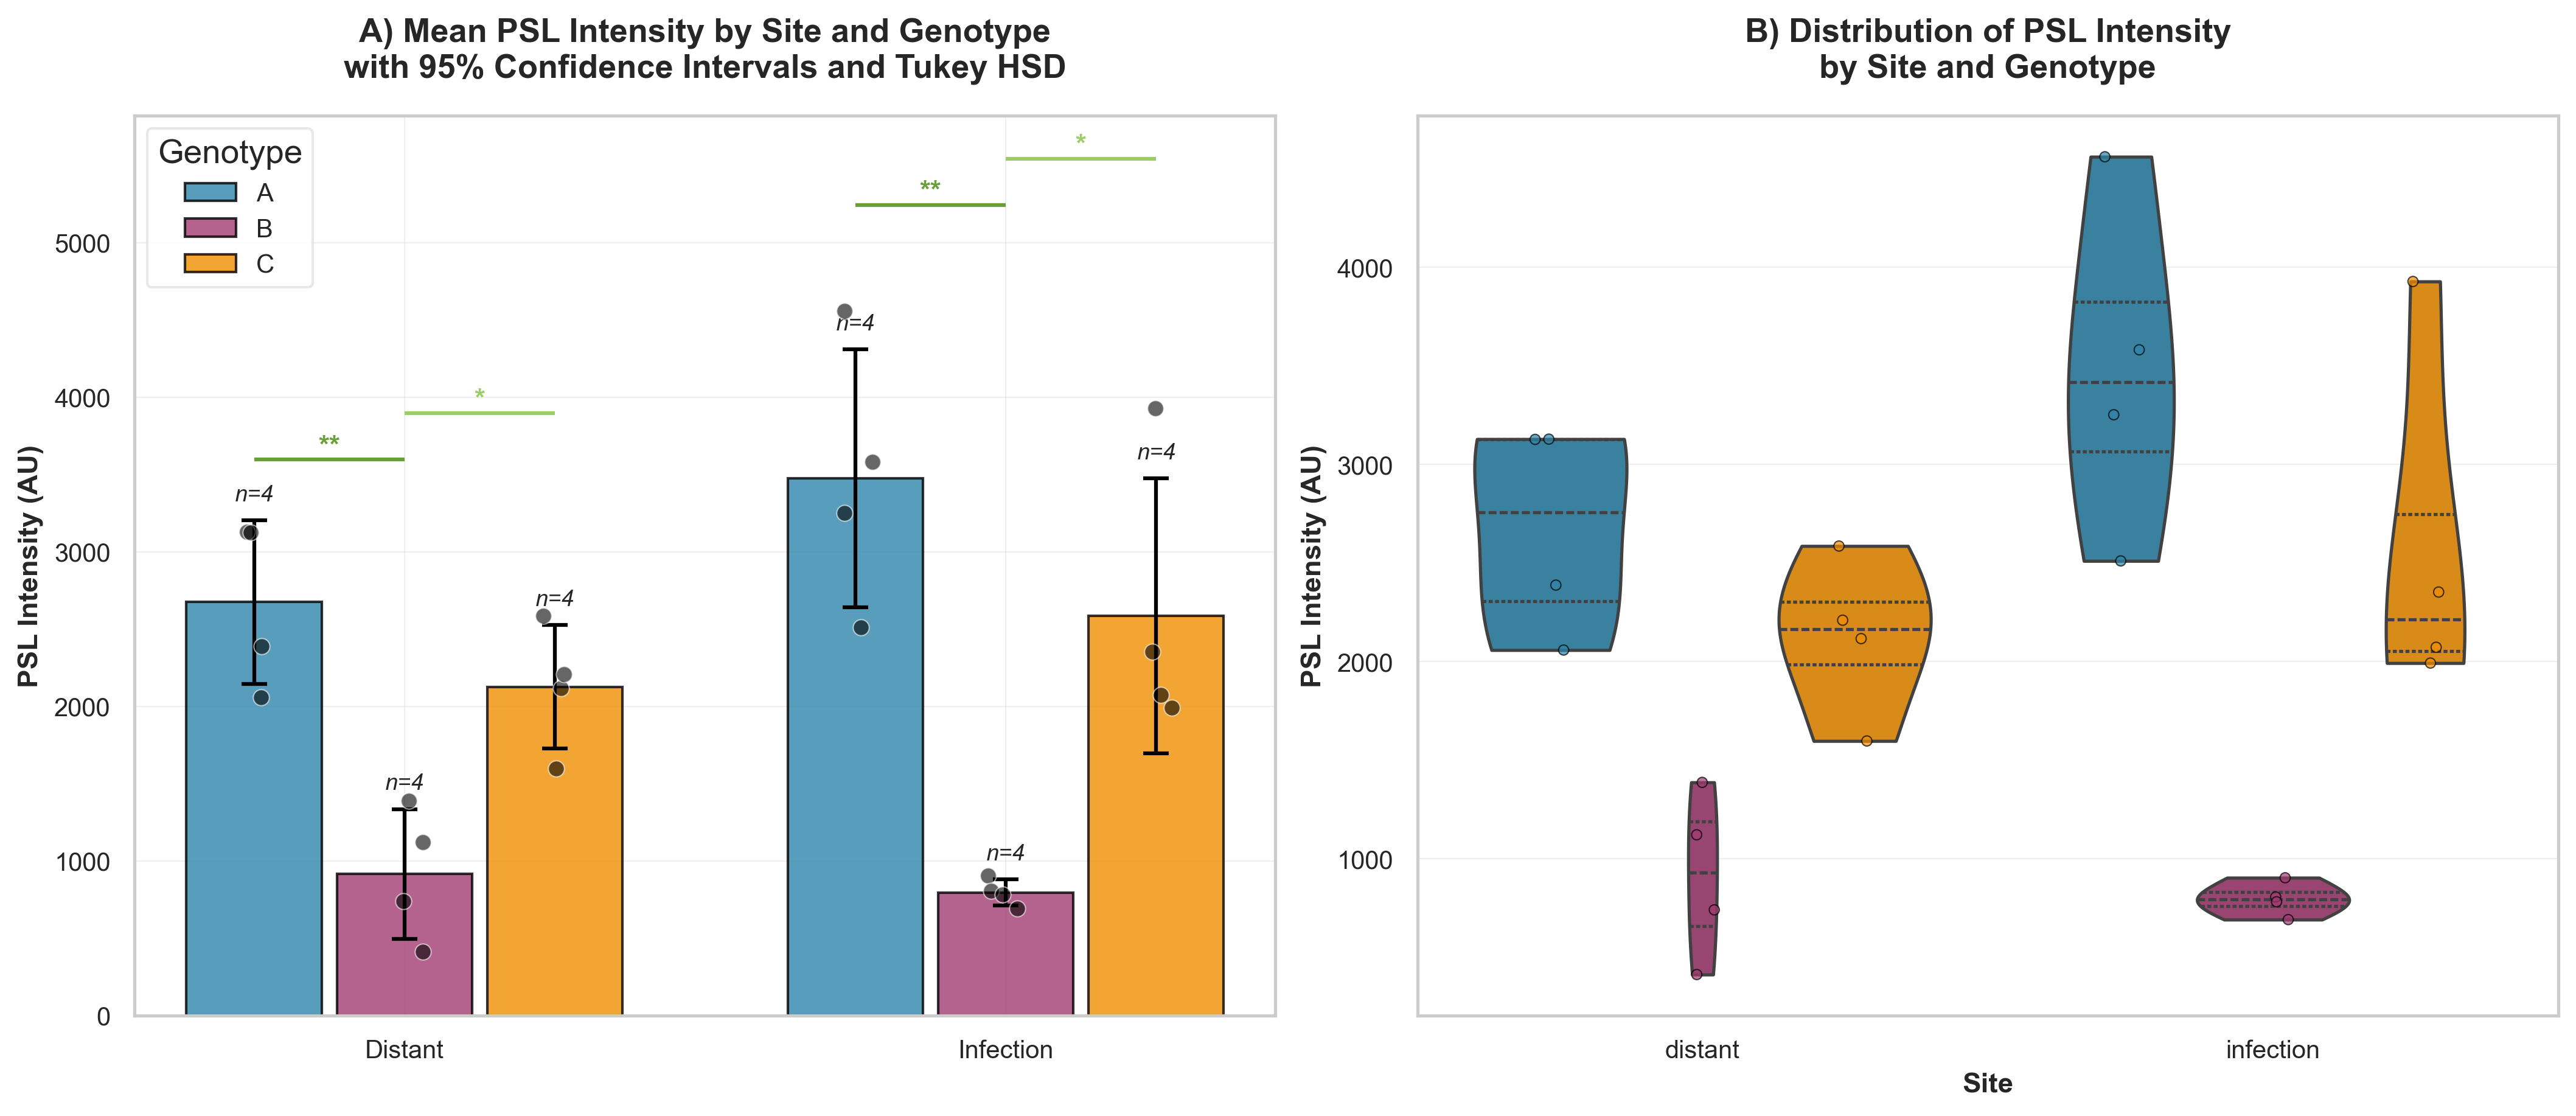

In [11]:
# Cell 10 — Enhanced main effects plot
print("Creating enhanced visualization: Main Effects Plot")

# Calculate summary statistics for plotting
summary_plot = df.groupby(['site', 'genotype']).agg({
    'psl_intensity': ['mean', 'sem', 'count', 'std']
}).round(2)

summary_plot.columns = ['mean', 'sem', 'n', 'std']
summary_plot['ci'] = summary_plot['sem'] * 1.96  # 95% CI

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot 1: Bar plot with confidence intervals
ax1 = axes[0]
site_order = ['distant', 'infection']
genotype_order = sorted(df['genotype'].unique())

# Calculate x positions
x_base = np.arange(len(site_order))
width = 0.25
x_positions = {}

for i, site in enumerate(site_order):
    site_data = summary_plot.loc[site]
    x = x_base[i] + np.arange(len(genotype_order)) * width - width
    
    for j, genotype in enumerate(genotype_order):
        if genotype in site_data.index:
            mean = site_data.loc[genotype, 'mean']
            ci = site_data.loc[genotype, 'ci']
            color = palette[genotype]
            n = site_data.loc[genotype, 'n']
            
            # Store position for later use
            x_positions[(site, genotype)] = x[j]
            
            # Plot bar
            ax1.bar(x[j], mean, width=width*0.9, 
                   color=color, alpha=0.8, 
                   edgecolor='black', linewidth=1,
                   label=genotype if i == 0 else "")
            
            # Plot error bar
            plot_confidence_interval(ax1, x[j], mean, ci, color='black')
            
            # Add individual data points
            individual_data = df[(df['site'] == site) & 
                                (df['genotype'] == genotype)]['psl_intensity']
            jitter = np.random.normal(0, 0.02, len(individual_data))
            ax1.scatter([x[j] + jitter[k] for k in range(len(individual_data))], 
                       individual_data, color='black', alpha=0.6, s=40,
                       edgecolor='white', linewidth=0.5, zorder=5)
            
            # Add sample size annotation
            ax1.text(x[j], mean + ci + 100, f'n={n}', 
                    ha='center', va='bottom', fontsize=9, fontstyle='italic')

# Add Tukey HSD annotations
for site in site_order:
    if site in tukey_results:
        tr = tukey_results[site]
        y_max = df[df['site'] == site]['psl_intensity'].max()
        y_start = y_max * 1.15
        
        for i, (_, row) in enumerate(tr.iterrows()):
            if row['reject']:
                g1, g2 = row['group1'], row['group2']
                if (site, g1) in x_positions and (site, g2) in x_positions:
                    x1 = x_positions[(site, g1)]
                    x2 = x_positions[(site, g2)]
                    p_val = float(row['p-adj'])
                    add_sig_bar(ax1, x1, x2, y_start + i*150, p_val)

ax1.set_xticks(x_base)
ax1.set_xticklabels([s.capitalize() for s in site_order])
ax1.set_ylabel('PSL Intensity (AU)', fontweight='semibold')
ax1.set_title('A) Mean PSL Intensity by Site and Genotype\nwith 95% Confidence Intervals and Tukey HSD',
             fontsize=13, fontweight='bold', pad=15)
ax1.legend(title='Genotype', frameon=True, framealpha=0.9)

# Plot 2: Violin plot showing distributions
ax2 = axes[1]
sns.violinplot(x='site', y='psl_intensity', hue='genotype',
               data=df, ax=ax2, palette=palette,
               inner='quartile', cut=0, saturation=0.8,
               order=site_order, hue_order=genotype_order)

# Add stripplot for individual points
sns.stripplot(x='site', y='psl_intensity', hue='genotype',
              data=df, ax=ax2, palette=palette,
              dodge=True, jitter=True, alpha=0.7, size=4,
              edgecolor='black', linewidth=0.5,
              order=site_order, hue_order=genotype_order)

ax2.set_xlabel('Site', fontweight='semibold')
ax2.set_ylabel('PSL Intensity (AU)', fontweight='semibold')
ax2.set_title('B) Distribution of PSL Intensity\nby Site and Genotype',
             fontsize=13, fontweight='bold', pad=15)
ax2.legend([], [], frameon=False)  # Remove duplicate legend

plt.savefig('figures/psl_main_effects.png', dpi=300)
print("Saved main effects figure to figures/psl_main_effects.png")
plt.show()

Creating enhanced visualization: Per-Site Genotype Comparisons
Saved genotype comparisons figure to figures/psl_genotype_comparisons.png


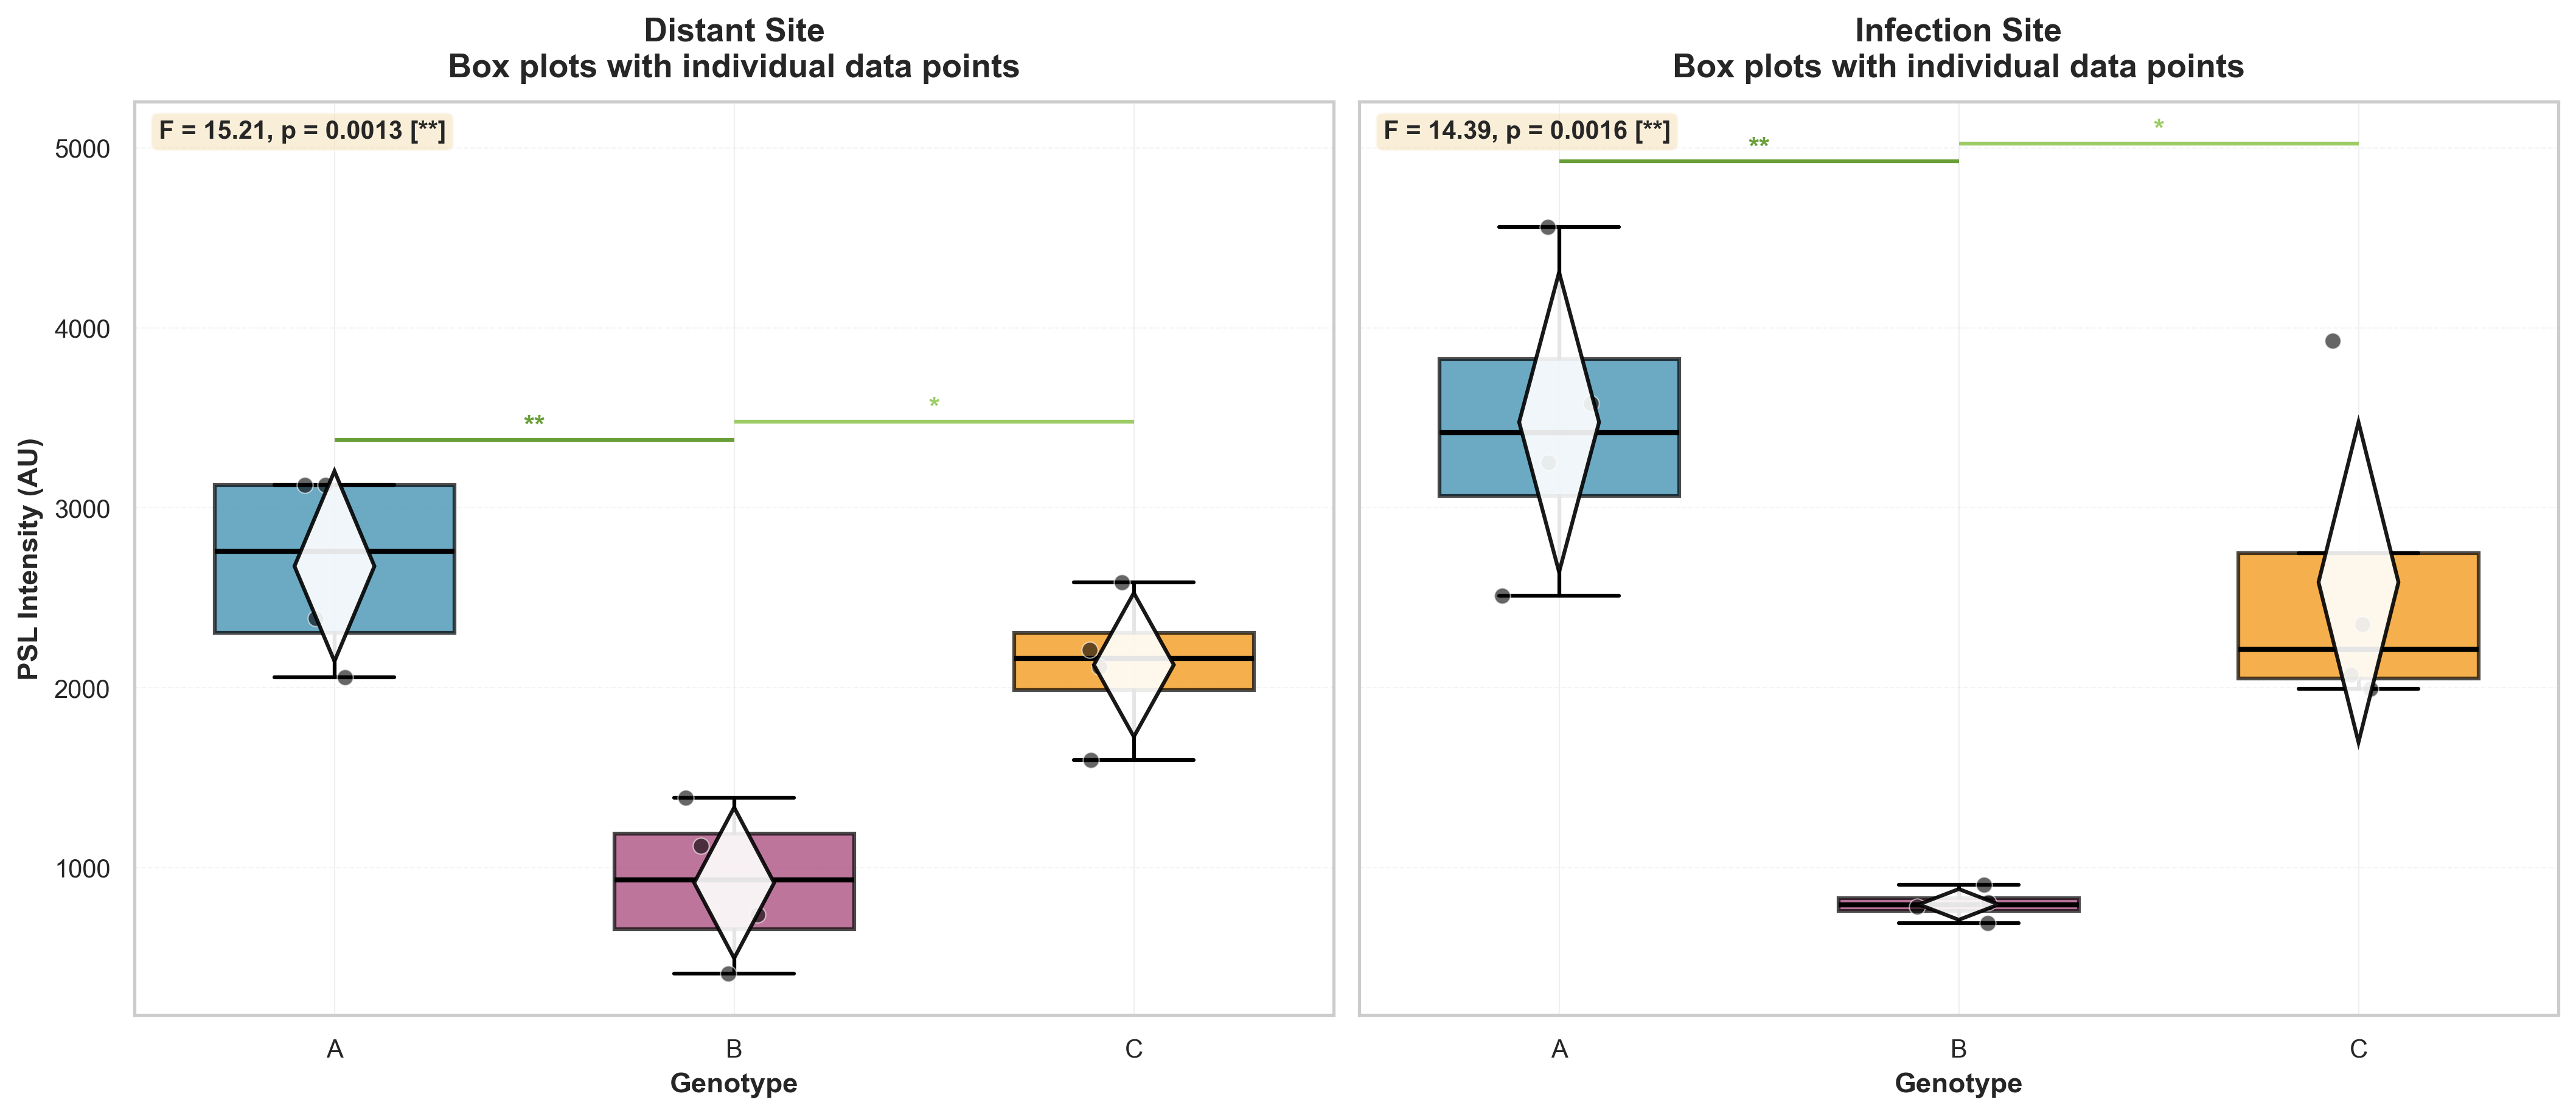

In [12]:
# Cell 11 — Detailed genotype comparisons per site
print("Creating enhanced visualization: Per-Site Genotype Comparisons")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, constrained_layout=True)

for idx, site in enumerate(['distant', 'infection']):
    ax = axes[idx]
    site_data = df[df['site'] == site]
    
    # Create boxplot
    box_data = [site_data[site_data['genotype'] == g]['psl_intensity'] 
                for g in genotype_order]
    
    bp = ax.boxplot(box_data, labels=genotype_order,
                    patch_artist=True,
                    widths=0.6,
                    showfliers=False,
                    medianprops=dict(color='black', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Color boxes
    for patch, genotype in zip(bp['boxes'], genotype_order):
        patch.set_facecolor(palette[genotype])
        patch.set_alpha(0.7)
    
    # Add individual data points with jitter
    for j, genotype in enumerate(genotype_order):
        genotype_data = site_data[site_data['genotype'] == genotype]['psl_intensity']
        x_pos = np.random.normal(j + 1, 0.08, len(genotype_data))
        ax.scatter(x_pos, genotype_data, color='black', alpha=0.6,
                  s=40, edgecolor='white', linewidth=0.5, zorder=3)
    
    # Add mean diamonds
    for j, genotype in enumerate(genotype_order):
        mean_val = site_data[site_data['genotype'] == genotype]['psl_intensity'].mean()
        sem_val = site_data[site_data['genotype'] == genotype]['psl_intensity'].sem()
        ci = sem_val * 1.96
        
        # Draw mean diamond
        diamond_x = [j + 1 - 0.1, j + 1, j + 1 + 0.1, j + 1, j + 1 - 0.1]
        diamond_y = [mean_val, mean_val + ci, mean_val, mean_val - ci, mean_val]
        ax.fill(diamond_x, diamond_y, color='white', 
                edgecolor='black', linewidth=1.5, zorder=4, alpha=0.9)
    
    # Add significance annotations from Tukey HSD
    if site in tukey_results:
        tr = tukey_results[site]
        y_max = site_data['psl_intensity'].max()
        y_start = y_max * 1.08
        
        sig_pairs = []
        for _, row in tr.iterrows():
            if row['reject']:
                sig_pairs.append((row['group1'], row['group2'], float(row['p-adj'])))
        
        for i, (g1, g2, p_val) in enumerate(sig_pairs):
            if g1 in genotype_order and g2 in genotype_order:
                x1 = genotype_order.index(g1) + 1
                x2 = genotype_order.index(g2) + 1
                add_sig_bar(ax, x1, x2, y_start + i*100, p_val)
    
    # Add ANOVA F-statistic
    if site in anova_results:
        F_val = anova_results[site].loc['C(genotype)', 'F']
        p_val = anova_results[site].loc['C(genotype)', 'PR(>F)']
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        ax.text(0.02, 0.98, f'F = {F_val:.2f}, p = {p_val:.4f} [{sig}]',
                transform=ax.transAxes, fontsize=10, fontweight='bold',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Genotype', fontweight='semibold')
    ax.set_ylabel('PSL Intensity (AU)' if idx == 0 else '', fontweight='semibold')
    ax.set_title(f'{site.capitalize()} Site\nBox plots with individual data points',
                fontsize=13, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.2, linestyle='--', axis='y')

plt.savefig('figures/psl_genotype_comparisons.png', dpi=300)
print("Saved genotype comparisons figure to figures/psl_genotype_comparisons.png")
plt.show()

Creating comprehensive results dashboard
Saved comprehensive dashboard to figures/psl_comprehensive_dashboard.png


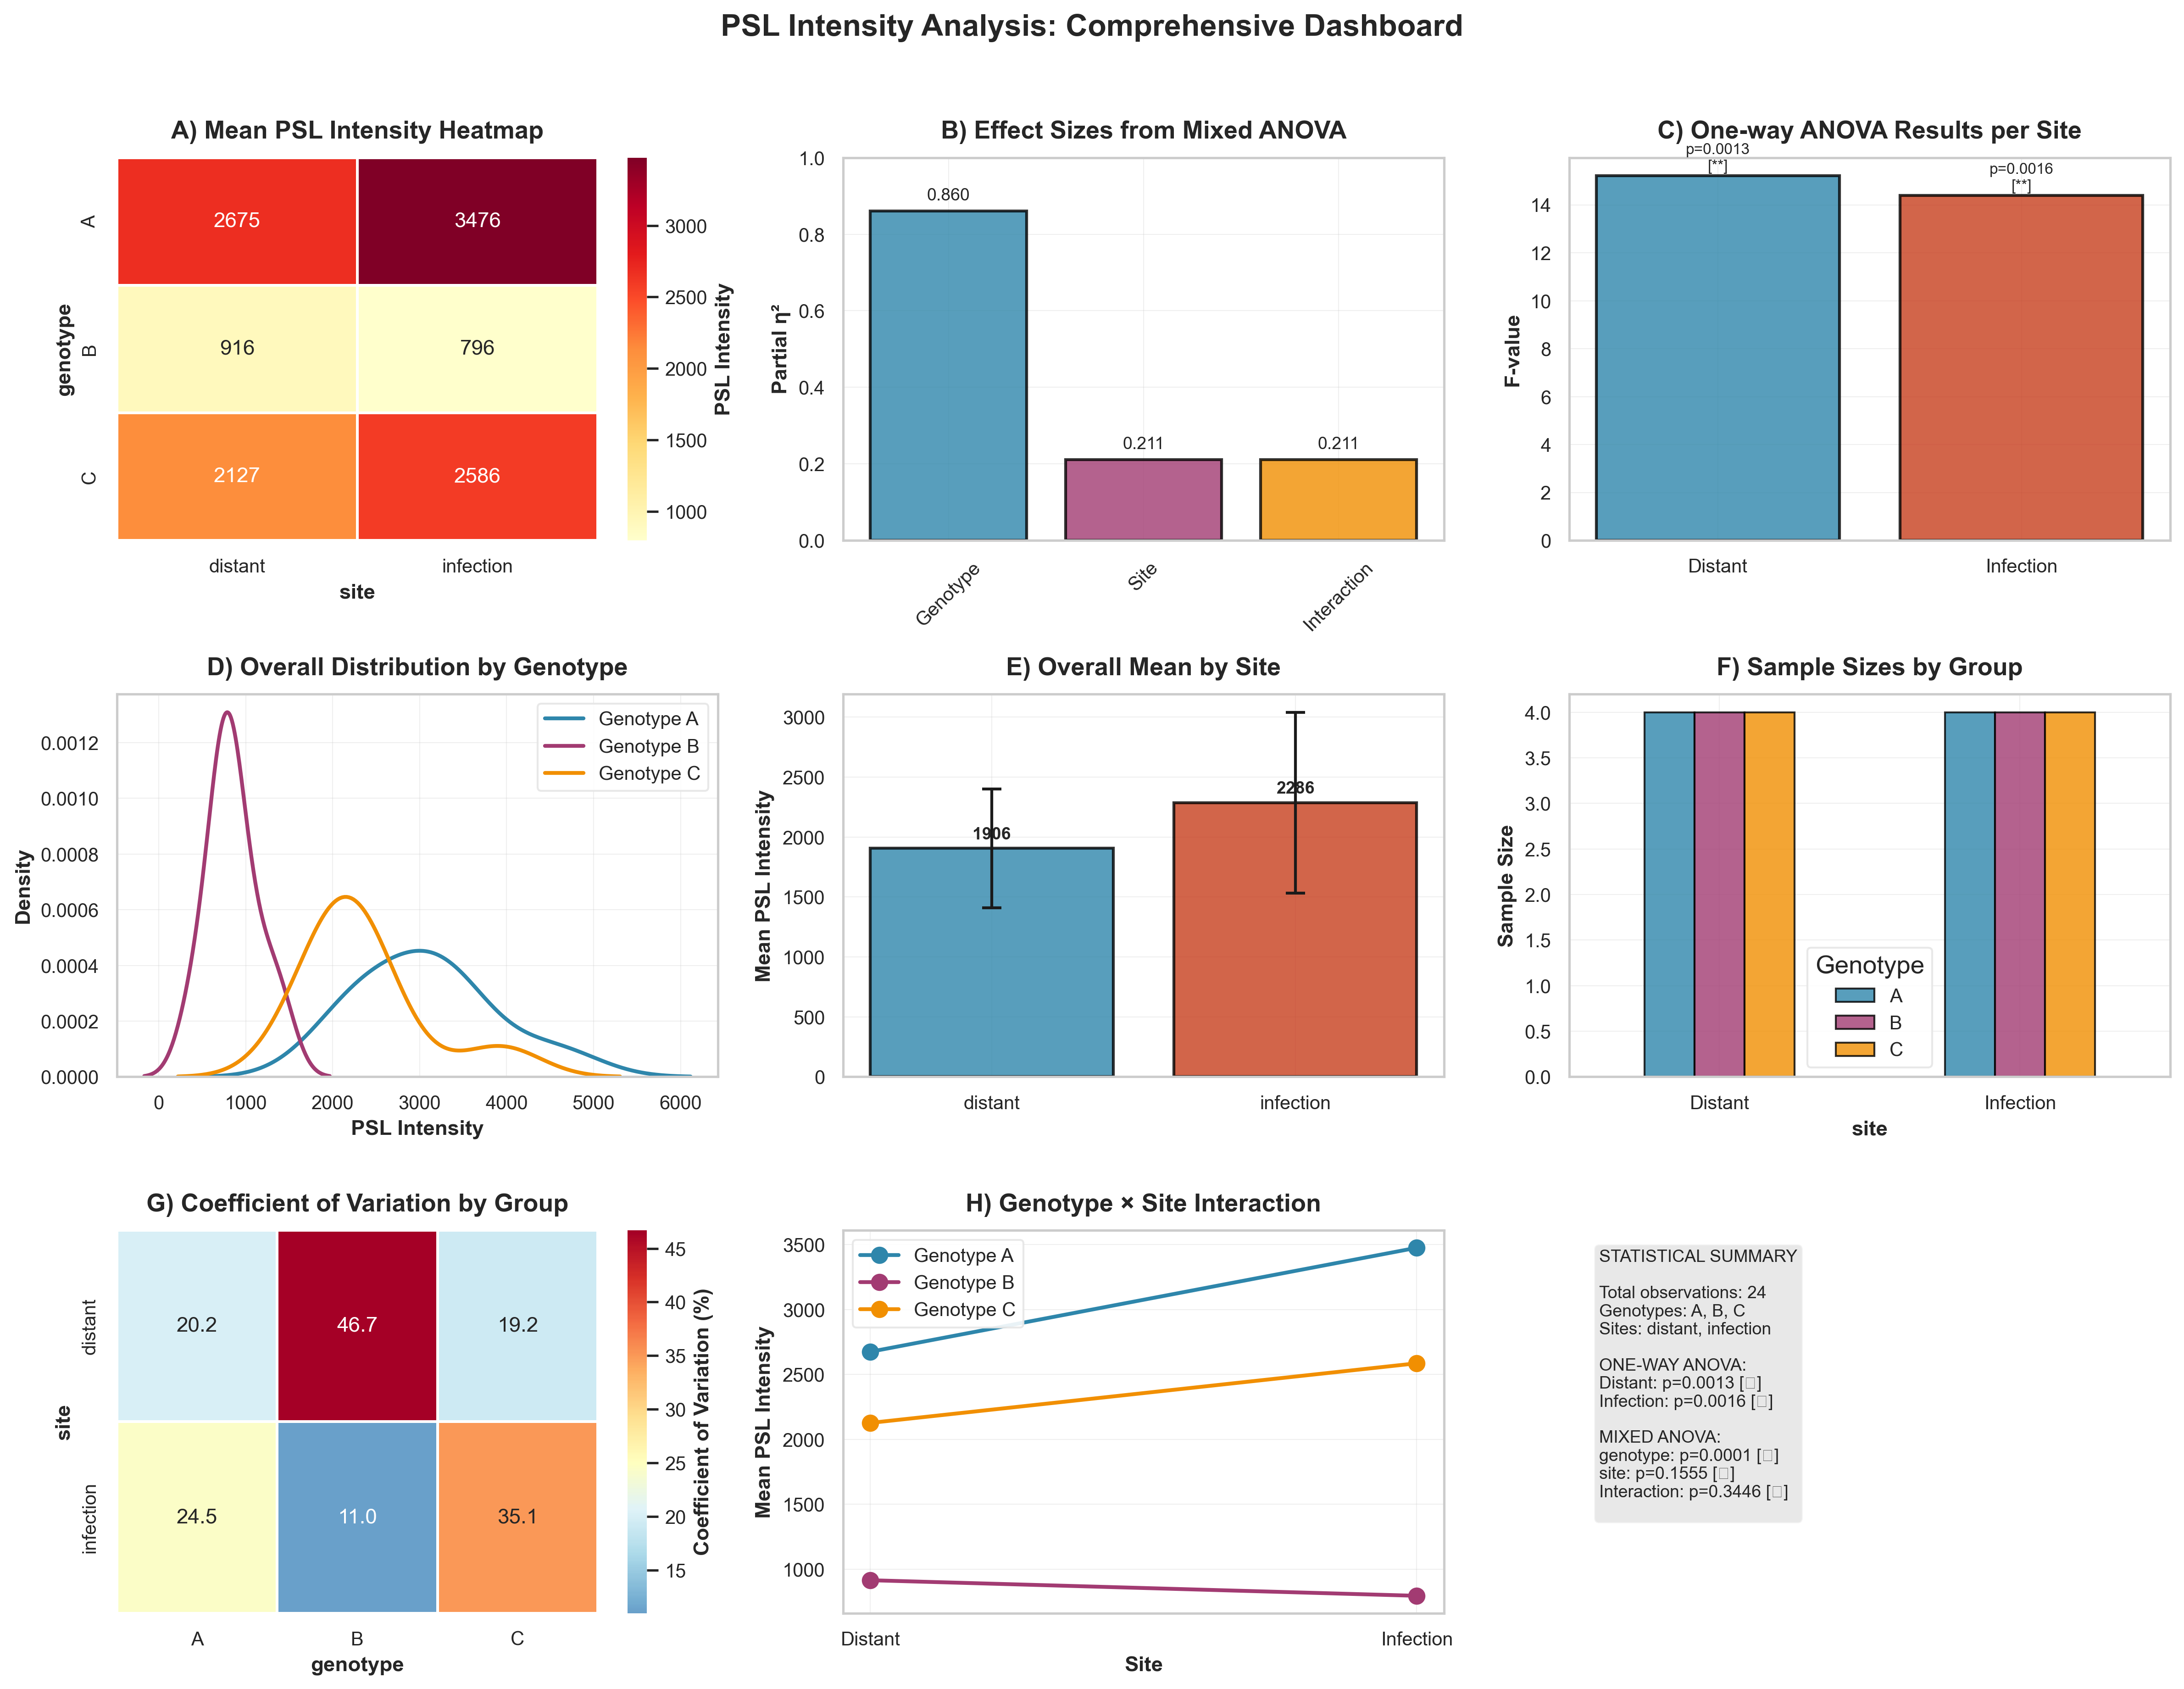

In [13]:
# Cell 13 — Comprehensive results dashboard
print("Creating comprehensive results dashboard")

# Calculate additional statistics for dashboard
dashboard_stats = []

for site in ['distant', 'infection']:
    for genotype in sorted(df['genotype'].unique()):
        data = df[(df['site'] == site) & (df['genotype'] == genotype)]['psl_intensity']
        
        if len(data) > 0:
            stats_dict = {
                'site': site,
                'genotype': genotype,
                'mean': data.mean(),
                'sd': data.std(),
                'sem': data.sem(),
                'n': len(data),
                'ci_lower': data.mean() - 1.96 * data.sem(),
                'ci_upper': data.mean() + 1.96 * data.sem(),
                'cv': (data.std() / data.mean()) * 100 if data.mean() != 0 else 0
            }
            dashboard_stats.append(stats_dict)

dashboard_df = pd.DataFrame(dashboard_stats).round(2)

# Create comprehensive figure
fig = plt.figure(figsize=(16, 12))

# 1. Heatmap of means (top left)
ax1 = plt.subplot(3, 3, 1)
heatmap_data = df.pivot_table(index='genotype', columns='site', 
                             values='psl_intensity', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
           cbar_kws={'label': 'PSL Intensity'}, ax=ax1, linewidths=1)
ax1.set_title('A) Mean PSL Intensity Heatmap', fontweight='bold', pad=10)

# 2. Effect sizes (top middle)
ax2 = plt.subplot(3, 3, 2)
if 'mixed_anova' in locals():
    effect_data = mixed_anova[mixed_anova['Source'] != 'Residual'][['Source', 'np2']]
    bars = ax2.bar(effect_data['Source'], effect_data['np2'],
                  color=['#2E86AB', '#A23B72', '#F18F01'],
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Partial η²', fontweight='semibold')
    ax2.set_title('B) Effect Sizes from Mixed ANOVA', fontweight='bold', pad=10)
    ax2.set_xticklabels(['Genotype', 'Site', 'Interaction'], rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, effect_data['np2']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 3. ANOVA F-values (top right)
ax3 = plt.subplot(3, 3, 3)
anova_data = []
for site in ['distant', 'infection']:
    if site in anova_results:
        anova_data.append({
            'Site': site.capitalize(),
            'F': anova_results[site].loc['C(genotype)', 'F'],
            'p': anova_results[site].loc['C(genotype)', 'PR(>F)']
        })
anova_plot_df = pd.DataFrame(anova_data)

bars = ax3.bar(anova_plot_df['Site'], anova_plot_df['F'],
              color=['#2E86AB', '#C73E1D'], alpha=0.8,
              edgecolor='black', linewidth=1.5)
ax3.set_ylabel('F-value', fontweight='semibold')
ax3.set_title('C) One-way ANOVA Results per Site', fontweight='bold', pad=10)

# Add p-value annotations
for bar, p_val in zip(bars, anova_plot_df['p']):
    height = bar.get_height()
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'p={p_val:.4f}\n[{sig}]', ha='center', va='bottom',
            fontsize=8)

# 4. Distribution comparison (middle left)
ax4 = plt.subplot(3, 3, 4)
for genotype in sorted(df['genotype'].unique()):
    genotype_data = df[df['genotype'] == genotype]['psl_intensity']
    sns.kdeplot(genotype_data, label=f'Genotype {genotype}',
               color=palette[genotype], ax=ax4, linewidth=2)
ax4.set_xlabel('PSL Intensity', fontweight='semibold')
ax4.set_ylabel('Density', fontweight='semibold')
ax4.set_title('D) Overall Distribution by Genotype', fontweight='bold', pad=10)
ax4.legend(frameon=True, framealpha=0.9)

# 5. Site comparison (middle middle)
ax5 = plt.subplot(3, 3, 5)
site_means = df.groupby('site')['psl_intensity'].agg(['mean', 'sem'])
site_means['ci'] = site_means['sem'] * 1.96

bars = ax5.bar(site_means.index, site_means['mean'],
              yerr=site_means['ci'],
              color=[site_palette[s] for s in site_means.index],
              alpha=0.8, edgecolor='black', linewidth=1.5,
              capsize=5, error_kw=dict(capthick=1.5, linewidth=1.5))
ax5.set_ylabel('Mean PSL Intensity', fontweight='semibold')
ax5.set_title('E) Overall Mean by Site', fontweight='bold', pad=10)

# Add value labels
for bar, mean_val in zip(bars, site_means['mean']):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{mean_val:.0f}', ha='center', va='bottom',
            fontsize=9, fontweight='bold')

# 6. Sample sizes (middle right)
ax6 = plt.subplot(3, 3, 6)
sample_sizes = df.groupby(['site', 'genotype']).size().unstack()
sample_sizes.plot(kind='bar', ax=ax6, color=[palette[g] for g in sample_sizes.columns],
                 edgecolor='black', linewidth=1, alpha=0.8)
ax6.set_ylabel('Sample Size', fontweight='semibold')
ax6.set_title('F) Sample Sizes by Group', fontweight='bold', pad=10)
ax6.legend(title='Genotype', frameon=True, framealpha=0.9)
ax6.set_xticklabels([s.capitalize() for s in sample_sizes.index], rotation=0)

# 7. Coefficient of variation (bottom left)
ax7 = plt.subplot(3, 3, 7)
cv_data = df.groupby(['site', 'genotype']).agg({
    'psl_intensity': ['mean', 'std']
})
cv_data.columns = ['mean', 'std']
cv_data['cv'] = (cv_data['std'] / cv_data['mean']) * 100

cv_wide = cv_data['cv'].unstack()
sns.heatmap(cv_wide, annot=True, fmt='.1f', cmap='RdYlBu_r',
           cbar_kws={'label': 'Coefficient of Variation (%)'},
           ax=ax7, linewidths=1, center=25)
ax7.set_title('G) Coefficient of Variation by Group', fontweight='bold', pad=10)

# 8. Interaction plot (bottom middle)
ax8 = plt.subplot(3, 3, 8)
interaction_data = df.groupby(['site', 'genotype'])['psl_intensity'].mean().unstack()

for genotype in genotype_order:
    ax8.plot(interaction_data.index, interaction_data[genotype],
            marker='o', markersize=8, linewidth=2,
            color=palette[genotype], label=f'Genotype {genotype}')

ax8.set_xlabel('Site', fontweight='semibold')
ax8.set_ylabel('Mean PSL Intensity', fontweight='semibold')
ax8.set_title('H) Genotype × Site Interaction', fontweight='bold', pad=10)
ax8.legend(frameon=True, framealpha=0.9)
ax8.set_xticks(range(len(interaction_data.index)))
ax8.set_xticklabels([s.capitalize() for s in interaction_data.index])

# 9. Statistical summary (bottom right)
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create text summary
summary_text = "STATISTICAL SUMMARY\n\n"
summary_text += f"Total observations: {len(df)}\n"
summary_text += f"Genotypes: {', '.join(sorted(df['genotype'].unique()))}\n"
summary_text += f"Sites: {', '.join(sorted(df['site'].unique()))}\n\n"

# Add ANOVA summary
summary_text += "ONE-WAY ANOVA:\n"
for site in ['distant', 'infection']:
    if site in anova_results:
        p_val = anova_results[site].loc['C(genotype)', 'PR(>F)']
        sig = "✓" if p_val < 0.05 else "✗"
        summary_text += f"{site.capitalize()}: p={p_val:.4f} [{sig}]\n"

summary_text += "\nMIXED ANOVA:\n"
if 'mixed_anova' in locals():
    for _, row in mixed_anova.iterrows():
        if row['Source'] != 'Residual':
            p_val = row['p-unc']
            sig = "✓" if p_val < 0.05 else "✗"
            summary_text += f"{row['Source']}: p={p_val:.4f} [{sig}]\n"

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.suptitle('PSL Intensity Analysis: Comprehensive Dashboard',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/psl_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
print("Saved comprehensive dashboard to figures/psl_comprehensive_dashboard.png")
plt.show()

In [14]:
# Cell 14 — Publication-ready tables
print("=" * 80)
print("PUBLICATION-READY TABLES")
print("=" * 80)

# Table 1: Descriptive statistics
print("\nTABLE 1: Descriptive Statistics")
print("-" * 80)
desc_table = df.groupby(['site', 'genotype'])['psl_intensity'].agg([
    'mean', 'std', 'sem', 'count', 'min', 'max'
]).round(2)
desc_table.columns = ['Mean', 'SD', 'SEM', 'N', 'Min', 'Max']
display(desc_table)

# Save as LaTeX
latex_desc = desc_table.to_latex(float_format="%.2f",
                                 caption="Descriptive statistics of PSL intensity by site and genotype",
                                 label="tab:descriptive")
with open('figures/descriptive_stats_latex.txt', 'w') as f:
    f.write(latex_desc)
print("LaTeX table saved to figures/descriptive_stats_latex.txt")

# Table 2: ANOVA results
print("\n\nTABLE 2: ANOVA Results")
print("-" * 80)
anova_table_data = []
for site in ['distant', 'infection']:
    if site in anova_results:
        anova_table_data.append({
            'Site': site.capitalize(),
            'F': f"{anova_results[site].loc['C(genotype)', 'F']:.3f}",
            'df1': int(anova_results[site].loc['C(genotype)', 'df']),
            'df2': int(anova_results[site].loc['Residual', 'df']),
            'p': f"{anova_results[site].loc['C(genotype)', 'PR(>F)']:.4f}",
            'η²': f"{(anova_results[site].loc['C(genotype)', 'sum_sq'] / (anova_results[site].loc['C(genotype)', 'sum_sq'] + anova_results[site].loc['Residual', 'sum_sq'])):.3f}"
        })

anova_table = pd.DataFrame(anova_table_data)
display(anova_table)

# Table 3: Mixed ANOVA results
if 'mixed_anova' in locals():
    print("\n\nTABLE 3: Mixed ANOVA Results")
    print("-" * 80)
    mixed_table = mixed_anova[mixed_anova['Source'] != 'Residual'][[
        'Source', 'F', 'DF1', 'DF2', 'p-unc', 'np2'
    ]].round(3)
    mixed_table.columns = ['Source', 'F', 'df1', 'df2', 'p', 'η²']
    display(mixed_table)

# Table 4: Post-hoc comparisons
print("\n\nTABLE 4: Post-hoc Comparisons (Tukey HSD)")
print("-" * 80)
posthoc_data = []
for site in ['distant', 'infection']:
    if site in tukey_results:
        for _, row in tukey_results[site].iterrows():
            posthoc_data.append({
                'Site': site.capitalize(),
                'Comparison': f"{row['group1']} vs {row['group2']}",
                'Mean Difference': f"{float(row['meandiff']):.1f}",
                '95% CI': f"[{float(row['lower']):.1f}, {float(row['upper']):.1f}]",
                'p (adj)': f"{float(row['p-adj']):.4f}",
                'Significant': 'Yes' if row['reject'] else 'No'
            })

posthoc_table = pd.DataFrame(posthoc_data)
display(posthoc_table)

# Save all tables to Excel
with pd.ExcelWriter('figures/psl_analysis_tables.xlsx') as writer:
    desc_table.to_excel(writer, sheet_name='Descriptive Stats')
    anova_table.to_excel(writer, sheet_name='ANOVA Results')
    if 'mixed_anova' in locals():
        mixed_table.to_excel(writer, sheet_name='Mixed ANOVA')
    posthoc_table.to_excel(writer, sheet_name='Post-hoc Comparisons')
    pairwise_df.to_excel(writer, sheet_name='Pairwise Comparisons')

print("\nAll tables saved to figures/psl_analysis_tables.xlsx")

PUBLICATION-READY TABLES

TABLE 1: Descriptive Statistics
--------------------------------------------------------------------------------


Mean      SD     SEM  N      Min      Max
site      genotype                                              
distant   A         2675.18  539.16  269.58  4  2058.31  3127.99
          B          915.66  427.50  213.75  4   412.79  1387.33
          C         2127.24  407.49  203.75  4  1597.24  2585.87
infection A         3475.65  850.25  425.12  4  2510.26  4559.83
          B          795.78   87.28   43.64  4   691.40   903.74
          C         2586.17  907.38  453.69  4  1992.33  3927.38

LaTeX table saved to figures/descriptive_stats_latex.txt


TABLE 2: ANOVA Results
--------------------------------------------------------------------------------


,Site,F,df1,df2,p,η²
0,Distant,15.212,2,9,0.0013,0.772
1,Infection,14.388,2,9,0.0016,0.762




TABLE 3: Mixed ANOVA Results
--------------------------------------------------------------------------------


,Source,F,df1,df2,p,η²
0,genotype,27.663,2,9,0.000,0.860
1,site,2.404,1,9,0.155,0.211
2,Interaction,1.202,2,9,0.345,0.211




TABLE 4: Post-hoc Comparisons (Tukey HSD)
--------------------------------------------------------------------------------


,Site,Comparison,Mean Difference,95% CI,p (adj),Significant
0,Distant,A vs B,-1759.5,"[-2671.0, -848.0]",0.0011,Yes
1,Distant,A vs C,-547.9,"[-1459.4, 363.6]",0.2650,No
2,Distant,B vs C,1211.6,"[300.1, 2123.1]",0.0121,Yes
3,Infection,A vs B,-2679.9,"[-4100.7, -1259.0]",0.0013,Yes
4,Infection,A vs C,-889.5,"[-2310.3, 531.4]",0.2408,No
5,Infection,B vs C,1790.4,"[369.5, 3211.2]",0.0162,Yes



All tables saved to figures/psl_analysis_tables.xlsx


In [15]:
# Cell 15 — Statistical assumptions checking
print("=" * 80)
print("STATISTICAL ASSUMPTIONS CHECKING")
print("=" * 80)

from scipy.stats import shapiro, levene, bartlett, kruskal

# 1. Normality tests
print("\n1. NORMALITY TESTS (Shapiro-Wilk):")
print("-" * 60)

normality_results = []
for site in df['site'].unique():
    for genotype in sorted(df['genotype'].unique()):
        data = df[(df['site'] == site) & (df['genotype'] == genotype)]['psl_intensity']
        
        if len(data) >= 3 and len(data) <= 5000:  # Shapiro-Wilk requirements
            stat, p = shapiro(data)
            normality_results.append({
                'Site': site,
                'Genotype': genotype,
                'W': round(stat, 4),
                'p': round(p, 4),
                'Normal': p > 0.05
            })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

# Count normal vs non-normal
normal_count = sum(normality_df['Normal'])
total_count = len(normality_df)
print(f"\n{normal_count}/{total_count} groups ({normal_count/total_count*100:.1f}%) "
      f"meet normality assumption (p > 0.05)")

# 2. Homogeneity of variance
print("\n\n2. HOMOGENEITY OF VARIANCE TESTS:")
print("-" * 60)

print("\nLevene's Test (robust to non-normality):")
for site in df['site'].unique():
    site_data = df[df['site'] == site]
    groups = [site_data[site_data['genotype'] == g]['psl_intensity'] 
              for g in sorted(site_data['genotype'].unique())]
    
    if all(len(g) > 1 for g in groups):  # Need at least 2 observations per group
        stat, p = levene(*groups)
        print(f"{site.capitalize()} site: W = {stat:.3f}, p = {p:.4f} "
              f"{'(homogeneous ✓)' if p > 0.05 else '(heterogeneous ✗)'}")

print("\nBartlett's Test (assumes normality):")
for site in df['site'].unique():
    site_data = df[df['site'] == site]
    groups = [site_data[site_data['genotype'] == g]['psl_intensity'] 
              for g in sorted(site_data['genotype'].unique())]
    
    if all(len(g) > 1 for g in groups):
        stat, p = bartlett(*groups)
        print(f"{site.capitalize()} site: T = {stat:.3f}, p = {p:.4f} "
              f"{'(homogeneous ✓)' if p > 0.05 else '(heterogeneous ✗)'}")

# 3. Outlier detection using IQR method
print("\n\n3. OUTLIER DETECTION (IQR method):")
print("-" * 60)

outliers_found = False
for site in df['site'].unique():
    for genotype in sorted(df['genotype'].unique()):
        data = df[(df['site'] == site) & (df['genotype'] == genotype)]['psl_intensity']
        
        if len(data) >= 4:  # Need at least 4 points for IQR method
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            
            if len(outliers) > 0:
                outliers_found = True
                print(f"{site.capitalize()} - {genotype}: "
                      f"{len(outliers)} outlier(s) - values: {list(outliers.round(2))}")

if not outliers_found:
    print("No outliers detected using IQR method (1.5 × IQR)")

# 4. Non-parametric alternatives for comparison
print("\n\n4. NON-PARAMETRIC ALTERNATIVES:")
print("-" * 60)

print("\nKruskal-Wallis Test (non-parametric alternative to one-way ANOVA):")
for site in df['site'].unique():
    site_data = df[df['site'] == site]
    groups = [site_data[site_data['genotype'] == g]['psl_intensity'] 
              for g in sorted(site_data['genotype'].unique())]
    
    if all(len(g) > 0 for g in groups):
        stat, p = kruskal(*groups)
        print(f"{site.capitalize()} site: H = {stat:.3f}, p = {p:.4f} "
              f"{'(significant ✓)' if p < 0.05 else '(not significant ✗)'}")

# 5. Recommendations based on assumptions
print("\n\n5. STATISTICAL RECOMMENDATIONS:")
print("-" * 60)

recommendations = []

# Check normality assumption
if normal_count < total_count * 0.8:  # Less than 80% groups normal
    recommendations.append("• Some groups violate normality assumption.")
    recommendations.append("  → Consider: Non-parametric tests (Kruskal-Wallis)")
    recommendations.append("  → Consider: Data transformation (log, square root)")

# Check homogeneity of variance
for site in df['site'].unique():
    site_data = df[df['site'] == site]
    groups = [site_data[site_data['genotype'] == g]['psl_intensity'] 
              for g in sorted(site_data['genotype'].unique())]
    
    if all(len(g) > 1 for g in groups):
        stat, p = levene(*groups)
        if p < 0.05:
            recommendations.append(f"• Heterogeneous variance detected for {site} site.")
            recommendations.append("  → Consider: Welch's ANOVA (corrects for unequal variances)")
            recommendations.append("  → Consider: Non-parametric alternatives")

# Check outliers
if outliers_found:
    recommendations.append("• Outliers detected in some groups.")
    recommendations.append("  → Consider: Robust statistical methods")
    recommendations.append("  → Consider: Sensitivity analysis with/without outliers")

# If no issues, confirm parametric tests are appropriate
if not recommendations:
    recommendations.append("• All assumptions met for parametric tests.")
    recommendations.append("  → Parametric ANOVA results are valid and optimal")

# Print recommendations
for rec in recommendations:
    print(rec)

# Save assumptions checking results
assumptions_df = pd.DataFrame(normality_results)
assumptions_df.to_csv('figures/statistical_assumptions.csv', index=False)
print("\n\nAssumptions checking results saved to figures/statistical_assumptions.csv")

STATISTICAL ASSUMPTIONS CHECKING

1. NORMALITY TESTS (Shapiro-Wilk):
------------------------------------------------------------


,Site,Genotype,W,p,Normal
0,infection,A,0.9875,0.9441,True
1,infection,B,0.9844,0.9273,True
2,infection,C,0.7671,0.0551,True
3,distant,A,0.8443,0.2082,True
4,distant,B,0.9802,0.9031,True
5,distant,C,0.9696,0.8390,True



6/6 groups (100.0%) meet normality assumption (p > 0.05)


2. HOMOGENEITY OF VARIANCE TESTS:
------------------------------------------------------------

Levene's Test (robust to non-normality):
Infection site: W = 1.241, p = 0.3343 (homogeneous ✓)
Distant site: W = 0.794, p = 0.4814 (homogeneous ✓)

Bartlett's Test (assumes normality):
Infection site: T = 8.943, p = 0.0114 (heterogeneous ✗)
Distant site: T = 0.244, p = 0.8850 (homogeneous ✓)


3. OUTLIER DETECTION (IQR method):
------------------------------------------------------------
Infection - C: 1 outlier(s) - values: [3927.38]


4. NON-PARAMETRIC ALTERNATIVES:
------------------------------------------------------------

Kruskal-Wallis Test (non-parametric alternative to one-way ANOVA):
Infection site: H = 8.346, p = 0.0154 (significant ✓)
Distant site: H = 8.000, p = 0.0183 (significant ✓)


5. STATISTICAL RECOMMENDATIONS:
------------------------------------------------------------
• Outliers detected in some groups.
  → C

In [16]:
# Cell 16 — Final summary and report generation
print("=" * 80)
print("FINAL ANALYSIS SUMMARY")
print("=" * 80)

# Calculate overall statistics
total_subjects = df['subject_id'].nunique()
total_observations = len(df)
genotypes = sorted(df['genotype'].unique())
sites = sorted(df['site'].unique())

print(f"\nSTUDY CHARACTERISTICS:")
print("-" * 40)
print(f"Total subjects: {total_subjects}")
print(f"Total observations: {total_observations}")
print(f"Genotypes: {', '.join(genotypes)}")
print(f"Sites: {', '.join(sites)}")

print(f"\nOVERALL DESCRIPTIVE STATISTICS:")
print("-" * 40)
overall_mean = df['psl_intensity'].mean()
overall_sd = df['psl_intensity'].std()
overall_range = (df['psl_intensity'].min(), df['psl_intensity'].max())
print(f"Mean ± SD: {overall_mean:.1f} ± {overall_sd:.1f}")
print(f"Range: {overall_range[0]:.1f} - {overall_range[1]:.1f}")

print(f"\nKEY FINDINGS:")
print("-" * 40)

# Summarize ANOVA results
print("1. ONE-WAY ANOVA RESULTS:")
for site in ['distant', 'infection']:
    if site in anova_results:
        p_val = anova_results[site].loc['C(genotype)', 'PR(>F)']
        if p_val < 0.05:
            print(f"   • {site.capitalize()} site: SIGNIFICANT genotype effect (p = {p_val:.4f})")
            # Report significant pairs
            if site in tukey_results:
                sig_pairs = tukey_results[site][tukey_results[site]['reject']]
                if not sig_pairs.empty:
                    for _, row in sig_pairs.iterrows():
                        diff = float(row['meandiff'])
                        print(f"     - {row['group1']} vs {row['group2']}: Δ = {abs(diff):.1f} "
                              f"({'higher' if diff > 0 else 'lower'})")
        else:
            print(f"   • {site.capitalize()} site: No significant genotype effect (p = {p_val:.4f})")

# Summarize mixed ANOVA results
if 'mixed_anova' in locals():
    print("\n2. MIXED ANOVA RESULTS:")
    for _, row in mixed_anova.iterrows():
        if row['Source'] != 'Residual':
            p_val = row['p-unc']
            effect = row['Source']
            
            if p_val < 0.05:
                print(f"   • {effect}: SIGNIFICANT (p = {p_val:.4f}, η² = {row['np2']:.3f})")
                if effect == 'Interaction':
                    print("     → Genotypes respond differently across sites")
                elif effect == 'genotype':
                    print("     → Overall genotype differences")
                elif effect == 'site':
                    print("     → Overall site differences")
            else:
                print(f"   • {effect}: Not significant (p = {p_val:.4f})")

print(f"\nEFFECT SIZES:")
print("-" * 40)
if 'mixed_anova' in locals():
    for _, row in mixed_anova.iterrows():
        if row['Source'] != 'Residual' and row['np2'] > 0:
            effect_size = row['np2']
            interpretation = ""
            if effect_size < 0.01:
                interpretation = "trivial"
            elif effect_size < 0.06:
                interpretation = "small"
            elif effect_size < 0.14:
                interpretation = "medium"
            else:
                interpretation = "large"
            
            print(f"   • {row['Source']}: η² = {effect_size:.3f} ({interpretation})")

print(f"\nDATA QUALITY:")
print("-" * 40)
print(f"Missing values: {df['psl_intensity'].isnull().sum()} / {len(df)} "
      f"({df['psl_intensity'].isnull().sum()/len(df)*100:.1f}%)")
print(f"Data completeness: {(1 - df['psl_intensity'].isnull().sum()/len(df))*100:.1f}%")

print(f"\nGENERATED OUTPUT FILES:")
print("-" * 40)
import glob
output_files = glob.glob('figures/*')
for file in sorted(output_files):
    file_size = os.path.getsize(file) / 1024  # Size in KB
    print(f"  • {os.path.basename(file)} ({file_size:.1f} KB)")

print(f"\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print("\nThe analysis has generated:")
print(f"  • {len(glob.glob('figures/*.png'))} visualization figures")
print(f"  • {len(glob.glob('figures/*.csv'))} data tables")
print(f"  • {len(glob.glob('figures/*.xlsx'))} Excel files")
print(f"  • {len(glob.glob('figures/*.txt'))} text files")

print("\nKey files for publication:")
print("  • figures/psl_main_effects.png - Main effects visualization")
print("  • figures/psl_paired_analysis.png - Paired measurements analysis")
print("  • figures/psl_comprehensive_dashboard.png - All results in one figure")
print("  • figures/psl_analysis_tables.xlsx - All statistical tables")
print("  • figures/descriptive_stats_latex.txt - LaTeX table for publication")

FINAL ANALYSIS SUMMARY

STUDY CHARACTERISTICS:
----------------------------------------
Total subjects: 12
Total observations: 24
Genotypes: A, B, C
Sites: distant, infection

OVERALL DESCRIPTIVE STATISTICS:
----------------------------------------
Mean ± SD: 2095.9 ± 1119.7
Range: 412.8 - 4559.8

KEY FINDINGS:
----------------------------------------
1. ONE-WAY ANOVA RESULTS:
   • Distant site: SIGNIFICANT genotype effect (p = 0.0013)
     - A vs B: Δ = 1759.5 (lower)
     - B vs C: Δ = 1211.6 (higher)
   • Infection site: SIGNIFICANT genotype effect (p = 0.0016)
     - A vs B: Δ = 2679.9 (lower)
     - B vs C: Δ = 1790.4 (higher)

2. MIXED ANOVA RESULTS:
   • genotype: SIGNIFICANT (p = 0.0001, η² = 0.860)
     → Overall genotype differences
   • site: Not significant (p = 0.1555)
   • Interaction: Not significant (p = 0.3446)

EFFECT SIZES:
----------------------------------------
   • genotype: η² = 0.860 (large)
   • site: η² = 0.211 (large)
   • Interaction: η² = 0.211 (large)

DA

In [17]:
# Cell 17 — Save complete notebook summary
import json
from datetime import datetime

# Create metadata file with analysis details
metadata = {
    "analysis_name": "PSL Intensity Analysis",
    "author": "Terence Makuvise",
    "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_file": "psl_data.csv",
    "total_observations": len(df),
    "total_subjects": df['subject_id'].nunique(),
    "genotypes": list(df['genotype'].unique()),
    "sites": list(df['site'].unique()),
    "variables": {
        "dependent": "psl_intensity",
        "between": "genotype",
        "within": "site",
        "subject": "subject_id"
    },
    "statistical_tests": {
        "one_way_anova": True,
        "tukey_hsd": True,
        "mixed_anova": True,
        "pairwise_comparisons": True,
        "assumptions_checking": True
    },
    "output_files": {
        "visualizations": glob.glob('figures/*.png'),
        "tables": glob.glob('figures/*.csv') + glob.glob('figures/*.xlsx'),
        "summary": glob.glob('figures/*.txt')
    }
}

# Save metadata
with open('figures/analysis_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("Analysis metadata saved to figures/analysis_metadata.json")

# Create README file
readme_content = f"""# PSL Intensity Analysis Report

## Analysis Overview
- Date: {datetime.now().strftime("%Y-%m-%d")}
- Author: Terence Makuvise
- Data file: psl_data.csv
- Total observations: {len(df)}
- Total subjects: {df['subject_id'].nunique()}

## Statistical Methods
1. **One-way ANOVA** for each site (infection, distant)
2. **Tukey HSD** post-hoc tests for genotype comparisons
3. **Mixed ANOVA** for genotype × site interactions
4. **Bonferroni-corrected** pairwise comparisons
5. **Statistical assumptions checking** (normality, homogeneity, outliers)

## Key Files Generated

### Visualizations
1. `psl_main_effects.png` - Main effects with 95% CIs and Tukey HSD
2. `psl_genotype_comparisons.png` - Per-site genotype comparisons
3. `psl_paired_analysis.png` - Paired measurements analysis
4. `psl_comprehensive_dashboard.png` - All results in one figure

### Data Tables
1. `psl_analysis_tables.xlsx` - All statistical tables in Excel format
2. `descriptive_statistics.csv` - Descriptive statistics
3. `pairwise_genotype_site_results.csv` - Pairwise comparisons
4. `mixed_anova_results.csv` - Mixed ANOVA results
5. `statistical_assumptions.csv` - Assumptions checking results

### Publication-ready Outputs
1. `descriptive_stats_latex.txt` - LaTeX table for manuscript
2. `analysis_metadata.json` - Complete analysis metadata

## How to Use This Analysis
1. Check `analysis_metadata.json` for complete analysis details
2. Use figures for presentations/publications
3. Reference tables for statistical results
4. Review assumptions checking for statistical validity

## Statistical Notes
- All p-values < 0.05 considered statistically significant
- Effect sizes (η²) interpreted as: <0.01 trivial, <0.06 small, <0.14 medium, ≥0.14 large
- 95% confidence intervals shown on all plots
- Bonferroni correction applied for multiple comparisons

## Contact
For questions about this analysis, contact: Terence Makuvise
"""

with open('figures/README.md', 'w') as f:
    f.write(readme_content)

print("README file saved to figures/README.md")
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - ALL FILES GENERATED")
print("=" * 80)

Analysis metadata saved to figures/analysis_metadata.json
README file saved to figures/README.md

ANALYSIS COMPLETE - ALL FILES GENERATED


## Interpretation notes (how to read results)
- **Per-site one-way ANOVAs**: examine `figures/anova_infection.csv` and `figures/anova_distant.csv` (if your sites are named that way) to see if genotype causes differences at each site; Tukey HSD tables show which pairs differ.  
- **Mixed ANOVA**: the `pg.mixed_anova(...)` table (if pingouin executed) tests main effects (genotype, site) and their interaction (genotype × site). A significant interaction indicates genotypes behave differently across sites.  
- **Pairwise tests**: `figures/pairwise_genotype_site_results.csv` contains pairwise t-tests with Bonferroni correction across genotype pairs at each site — useful to annotate plots or for reporting specific contrasts.

### Notes about assumptions and best practice
- ANOVA assumes approximate normality and homoscedasticity. If sample sizes are small, consider non-parametric alternatives (Kruskal–Wallis per site and Wilcoxon / Mann-Whitney for pairs).  
- For the repeated-measures design, `subject_id` must correctly pair infection and distant observations for the same subject. If `subject_id` is missing or pairing is not present, the mixed ANOVA (within-subject test) is NOT appropriate and was skipped/approximated.
